In [ ]:
# ====== BATCH 1: SIMPLE PREPROCESSING ======

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

# Load your dataset
data = pd.read_csv('/content/Sleep_health_and_lifestyle_dataset.csv')
# Fill missing Sleep Disorder with "None"
data["Sleep Disorder"] = data["Sleep Disorder"].fillna("None")

# Create target variable (1 = Sleep Apnea, 0 = None)
data["Sleep_Disorder"] = data["Sleep Disorder"].apply(lambda x: 1 if x == "Sleep Apnea" else 0)

# Split Blood Pressure into systolic & diastolic
bp_split = data["Blood Pressure"].str.split("/", expand=True)
data["Systolic"] = pd.to_numeric(bp_split[0], errors="coerce")
data["Diastolic"] = pd.to_numeric(bp_split[1], errors="coerce")

# Drop unnecessary columns
data = data.drop(columns=["Person ID", "Blood Pressure", "Sleep Disorder"])

# Encode categorical variables
label = LabelEncoder()
data["Gender"] = label.fit_transform(data["Gender"])
data["BMI Category"] = label.fit_transform(data["BMI Category"])
data["Occupation"] = label.fit_transform(data["Occupation"])

# Handle missing values (if any)
data = data.fillna(data.mean(numeric_only=True))

# Scale all features between 0 and 1
scaler = MinMaxScaler()
scaled_data = pd.DataFrame(scaler.fit_transform(data), columns=data.columns)

# Split into features (X) and target (y)
X = scaled_data.drop(columns=["Sleep_Disorder"])
y = scaled_data["Sleep_Disorder"]

# Train-test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("✅ Data Ready for MLP!")
print("Training shape:", X_train.shape)
print("Testing shape:", X_test.shape)
print("Columns:", list(X.columns))


✅ Data Ready for MLP!
Training shape: (299, 12)
Testing shape: (75, 12)
Columns: ['Gender', 'Age', 'Occupation', 'Sleep Duration', 'Quality of Sleep', 'Physical Activity Level', 'Stress Level', 'BMI Category', 'Heart Rate', 'Daily Steps', 'Systolic', 'Diastolic']


In [ ]:
data.head()

,Gender,Age,Occupation,Sleep Duration,Quality of Sleep,Physical Activity Level,Stress Level,BMI Category,Heart Rate,Daily Steps,Sleep_Disorder,Systolic,Diastolic
0,1,27,9,6.1,6,42,6,3,77,4200,0,126,83
1,1,28,1,6.2,6,60,8,0,75,10000,0,125,80
2,1,28,1,6.2,6,60,8,0,75,10000,0,125,80
3,1,28,6,5.9,4,30,8,2,85,3000,1,140,90
4,1,28,6,5.9,4,30,8,2,85,3000,1,140,90


In [ ]:
# ====== BATCH 2: MLP MODEL BUILDING (Keras) ======
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam

def build_mlp(input_dim,
              hidden_sizes=(64, 32),
              dropout=0.2,
              lr=1e-3):

    model = Sequential()
    model.add(Input(shape=(input_dim,)))
    # Hidden layers
    for i, h in enumerate(hidden_sizes):
        model.add(Dense(h, activation='relu'))
        # add dropout after the first hidden layer only (optional)
        if i == 0 and dropout and dropout > 0:
            model.add(Dropout(dropout))
    # Output layer (sigmoid for binary)
    model.add(Dense(1, activation='sigmoid'))

    # Compile
    opt = Adam(learning_rate=lr)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Example: build model using the preprocessed X_train from Batch 1
input_dim = X_train.shape[1]   # assumes Batch 1 created X_train
model = build_mlp(input_dim, hidden_sizes=(64,32), dropout=0.2, lr=1e-3)
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,945 (11.50 KB)

 Trainable params: 2,945 (11.50 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# ====== BATCH 3: TRAINING + EVALUATION ======
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns

# Early stopping to prevent overfitting
early_stop = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)

# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=50,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

# ===== Evaluate =====
# Predict probabilities
y_pred_prob = model.predict(X_test)
# Convert to class labels (0 or 1)
y_pred = (y_pred_prob >= 0.5).astype(int)

# Compute accuracy
acc = accuracy_score(y_test, y_pred)
print(f"\n✅ Test Accuracy: {acc:.4f}\n")

# Detailed classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))




Epoch 1/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9470 - loss: 0.1768 - val_accuracy: 0.9200 - val_loss: 0.2145
Epoch 2/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9605 - loss: 0.1290 - val_accuracy: 0.9200 - val_loss: 0.2280
Epoch 3/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9444 - loss: 0.1835 - val_accuracy: 0.9067 - val_loss: 0.2234
Epoch 4/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9513 - loss: 0.1739 - val_accuracy: 0.9200 - val_loss: 0.2234
Epoch 5/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9513 - loss: 0.1746 - val_accuracy: 0.9200 - val_loss: 0.2208
Epoch 6/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9454 - loss: 0.1575 - val_accuracy: 0.9200 - val_loss: 0.2242
Epoch 7/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9692 - loss: 0.1143 - val_accuracy: 0.9200 - val_loss: 0.2231
Epoch 8/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9600 - loss: 0.1595 - val_accuracy: 0.9200 - v

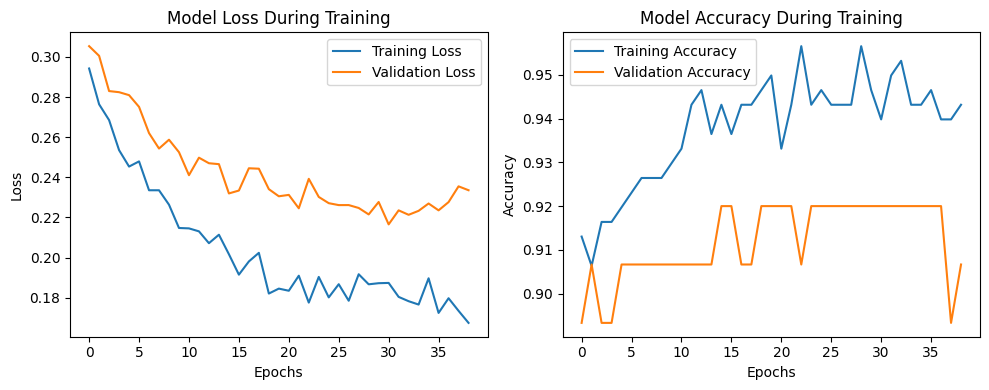

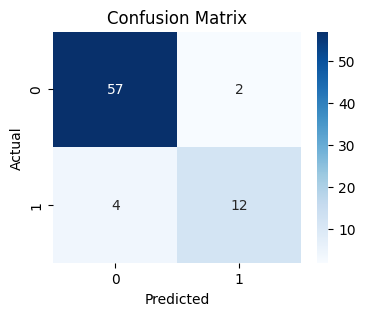

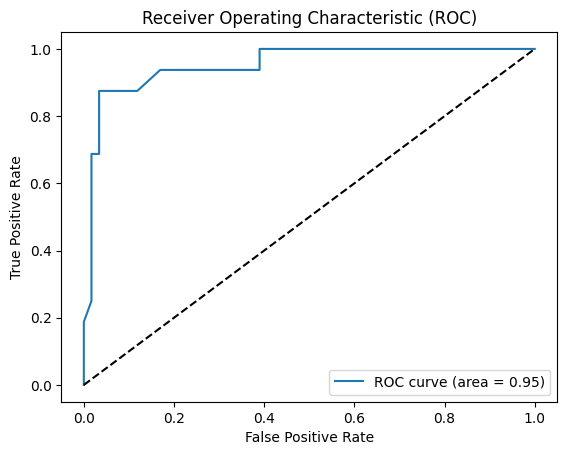

In [ ]:
# ====== BATCH 4: VISUALIZATION ======
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc

# --- 1. Training Curves ---
plt.figure(figsize=(10,4))

# Loss
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss During Training')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Accuracy
plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy During Training')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# --- 2. Confusion Matrix ---
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(4,3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# --- 3. ROC Curve (optional but looks great) ---
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0,1], [0,1], 'k--')
plt.title('Receiver Operating Characteristic (ROC)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()
